In [41]:
import ee
import geemap
import os
import dotenv
import base64
import textwrap
from PIL import Image
import numpy as np
from openai import OpenAI
import requests
import h5py
import os
import folium
from IPython.display import display
from shapely.geometry import Point

# Code Relevant to Google Earth Engine

In [171]:
# Google Earth Engine
ee.Authenticate()
ee.Initialize(project='iconic-guard-454717-v9')
dataset = 'COPERNICUS/S2_SR_HARMONIZED'


# Get Data from Google Earth Engine
def getSatImageryGEE(c1, c2):
    location = ee.Geometry.Point([c2 , c1])
    region = location.buffer(7000) 
    image = ee.ImageCollection(dataset) \
                .filterBounds(region) \
                .filterDate('2023-06-01', '2024-06-30') \
                .sort('CLOUDY_PIXEL_PERCENTAGE') \
                .first() \
                .select(['B4', 'B3', 'B2'])  # RGB bands

    return image, region

# Download the Data parsed from GEE
def downloadSatIGEE(c1, c2):
    image, region = getSatImageryGEE(c1, c2)
    geemap.ee_export_image(
        image, filename='satimagery/sentinel_rgb.tif', scale=10, region=region
        # Scale = 10m
    )

# Convert tif -> jpg
def GEE_to_brightJPG():
    img = Image.open("satimagery/sentinel_rgb.tif")

    # Convert to RGB and normalize brightness
    img = img.convert("RGB")

    # Enhance brightness slightly (optional)
    img = Image.eval(img, lambda x: x * 50)  # brighten by factor of 2

    # Save as JPEG
    img.save("satimagery/sentinel_rgb.jpg", "JPEG")
    print("Image Converted to JPG.")

# Encode the image because apparently gpt can't accept it otherwise
def prepareJPG_forOpenAI():
    with open("satimagery/sentinel_rgb.jpg", "rb") as f:
        base64_image = base64.b64encode(f.read()).decode("utf-8")

    # Format for OpenAI model
    image_content = {
        "type": "image_url",
        "image_url": {
            "url": f"data:image/jpeg;base64,{base64_image}"
        }
    }
    return image_content

# Download + Convert + PrepForOpenAI
def getGEEImagery(c1, c2):
    downloadSatIGEE(c1, c2)
    GEE_to_brightJPG()
    ex = prepareJPG_forOpenAI()
    
    print("Image Prepared for OpenAI export.")
    return ex

# Code Relevant to OpenAI

In [177]:
# OpenAI
dotenv.load_dotenv()

if not os.getenv("GITHUB_TOKEN"):
    raise ValueError("GITHUB_TOKEN is not set")

os.environ["OPENAI_API_KEY"] = os.getenv("GITHUB_TOKEN")
os.environ["OPENAI_BASE_URL"] = "https://models.github.ai/inference"

model = "openai/o3-mini" # or "openai/gpt-4o"
client = OpenAI()

# Sending Prompt + Image to OpenAI Model
def promptModel(p, i):
    modeloutput = client.chat.completions.create(
        messages=[
            {"role": "system", "content": "You're a geospatial analyst."},
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": p},
                    i
                ]
            }
        ],
        temperature=1.0,
        top_p=1.0,
        model=model
    )
    return modeloutput

# Sending Prompt to OpenAI Model
def promptONLY(p):
    modeloutput = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You're a geospatial analyst."},
            {"role": "user", "content": p}
        ],
        temperature=1.0,
        top_p=1.0,
    )
    return modeloutput


# Printing Data
def printoutput(r, d, option):
    print("\n")
    print(f"OpenAI Model: {model}")
    print(f"Dataset ID: {d} \n")
    print("Model Response:")
    content = r.choices[0].message.content

    if option == 1:
        wrapped = textwrap.fill(content, width=100)
        print(wrapped)
    elif option == 2:
        sections = content.split('*')
        for section in sections:
            print(section.strip())


# Prompt OpenAI Model + Attach Image
def promptGPT(c1, c2, p, option):
    if option == 1:
        imagePreped = getGEEImagery(c1, c2)
        return promptModel(p, imagePreped)
    elif option == 2:
        return promptONLY(p)

# GEE Implementation

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point, box

In [2]:
# Load the Amazonia shapefile data
amazonia_gdf = gpd.read_file("amazonia_boundary_proposal/amazonia_polygons.shp")

# Display basic information about the dataset
print("Dataset Info:")
print(f"Shape: {amazonia_gdf.shape}")
print(f"CRS: {amazonia_gdf.crs}")
print(f"Columns: {amazonia_gdf.columns.tolist()}")
print("\nFirst few rows:")
print(amazonia_gdf.head())

Dataset Info:
Shape: (249, 6)
CRS: EPSG:4326
Columns: ['AREA', 'PERIMETER', 'LINE_BOTH_', 'LINE_BOTH1', 'name', 'geometry']

First few rows:
        AREA  PERIMETER  LINE_BOTH_  LINE_BOTH1    name  \
0  85.082703  89.152802           2           1  Guiana   
1   0.000816   0.185337           3           0  Guiana   
2   0.004660   0.376014           4           0  Guiana   
3   0.005000   0.362444           5           0  Guiana   
4   0.001275   0.233949           6           0  Guiana   

                                            geometry  
0  POLYGON ((-63.95834 7.93139, -63.95084 7.93806...  
1  POLYGON ((-58.46997 7.02631, -58.47314 7.03369...  
2  POLYGON ((-58.50943 6.90474, -58.51149 6.90706...  
3  POLYGON ((-58.46499 6.87777, -58.46693 6.89594...  
4  POLYGON ((-58.55544 6.87011, -58.55797 6.87013...  


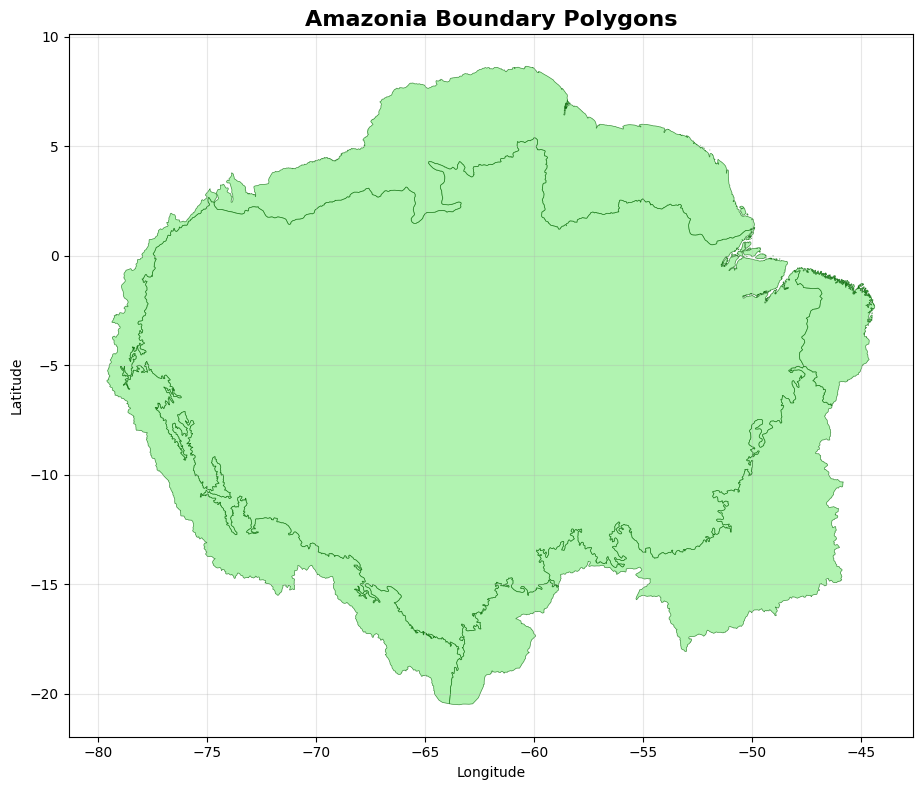


Dataset Statistics:
Total number of polygons: 249
Total area: 666.39 square degrees
Bounding box: [-79.59874725 -20.50092316 -44.35777664   8.64711571]


C:\Users\shaaf\AppData\Local\Temp\ipykernel_33620\748648217.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(f"Total area: {amazonia_gdf.geometry.area.sum():.2f} square degrees")


In [3]:
# Visualize the Amazonia polygons
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot the polygons
amazonia_gdf.plot(ax=ax, 
                  color='lightgreen', 
                  edgecolor='darkgreen', 
                  alpha=0.7,
                  linewidth=0.5)

# Add title and labels
ax.set_title('Amazonia Boundary Polygons', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add grid
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and display statistics
print(f"\nDataset Statistics:")
print(f"Total number of polygons: {len(amazonia_gdf)}")
print(f"Total area: {amazonia_gdf.geometry.area.sum():.2f} square degrees")
print(f"Bounding box: {amazonia_gdf.total_bounds}")

In [ ]:
X = -3.314660
Y = -61.355873


# Check if your Manaus coordinates are within the Amazonia boundary
manaus_point = Point(Y, X)  # Note: Point(longitude, latitude)
manaus_gdf = gpd.GeoDataFrame([1], geometry=[manaus_point], crs=amazonia_gdf.crs)

# Check if point is within any of the polygons
is_within = amazonia_gdf.contains(manaus_point).any()
print(f"Is Manaus ({X}, {Y}) within Amazonia boundary? {is_within}")

# Visualize Manaus location on the Amazonia map
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot Amazonia polygons
amazonia_gdf.plot(ax=ax, 
                  color='lightgreen', 
                  edgecolor='darkgreen', 
                  alpha=0.7,
                  linewidth=0.5,
                  label='Amazonia Boundary')

# Plot Manaus location
manaus_gdf.plot(ax=ax, 
                color='red', 
                markersize=100, 
                label='Manaus Location')

# Add title and labels
ax.set_title('Amazonia Boundary with Manaus Location', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

NameError: name 'Y' is not defined

In [ ]:
# Advanced Analysis: Clip satellite analysis to Amazonia boundaries
def analyzeWithinAmazonia(lat, lon, prompt_text):
    """
    Analyze satellite imagery only if the coordinates are within Amazonia boundaries
    """
    point = Point(lon, lat)
    is_within = amazonia_gdf.contains(point).any()
    
    if is_within:
        print(f"Coordinates ({lat}, {lon}) are within Amazonia boundary.")
        print("Proceeding with satellite analysis...")
        
        # Get satellite imagery and analyze with OpenAI
        result = promptGPT(lat, lon, prompt_text, 1)
        return result, True
    else:
        print(f"Coordinates ({lat}, {lon}) are outside Amazonia boundary.")
        print("Skipping satellite analysis.")
        return None, False

# Function to get multiple analysis points within Amazonia
def getAmazoniaAnalysisPoints(n_points=5):
    """
    Generate random points within Amazonia boundaries for analysis
    """
    # Get bounding box of Amazonia
    minx, miny, maxx, maxy = amazonia_gdf.total_bounds
    
    analysis_points = []
    attempts = 0
    max_attempts = n_points * 10
    
    while len(analysis_points) < n_points and attempts < max_attempts:
        # Generate random point within bounding box
        random_lon = np.random.uniform(minx, maxx)
        random_lat = np.random.uniform(miny, maxy)
        point = Point(random_lon, random_lat)
        
        # Check if point is within Amazonia
        if amazonia_gdf.contains(point).any():
            analysis_points.append((random_lat, random_lon))
        
        attempts += 1
    
    return analysis_points

# Generate analysis points
analysis_points = getAmazoniaAnalysisPoints(3)
print(f"Generated {len(analysis_points)} analysis points within Amazonia:")
for i, (lat, lon) in enumerate(analysis_points):
    print(f"Point {i+1}: ({lat:.6f}, {lon:.6f})")

# External DataSets I found
appEEARS_AmazonRainforest = "https://appeears.earthdatacloud.nasa.gov/download/1a6f2238-d420-498e-9bd7-6340ed3268ed"

DataSet ID = MCD12Q1.061

DataSet Name = MODIS Land Cover Type Yearly L3 Global 500m

In [94]:
X = -3.314660
Y = -61.355873

A = getGEEImagery(X, Y)

Generating URL ...
Please wait ...
Data downloaded to c:\Users\shaaf\OneDrive\Desktop\Shaaf Media\Coding\GitHub Files\OpenAI-to-Z-challenge\satimagery\sentinel_rgb.tif
Image Converted to JPG.
Image Prepared for OpenAI export.


In [180]:
# Coordinates for Manaus, Brazil (Amazon Rainforest)

## Only Works for GPT 4.1
## GEE data are images and other OpenAI models do not support direct
## image dump
dataset_GEE = ""
prompt = "Describe surface features in plain English based on this satellite image."

printoutput(promptGPT(X, Y, prompt, 1), dataset, 1)

Generating URL ...
Please wait ...
Data downloaded to c:\Users\shaaf\OneDrive\Desktop\Shaaf Media\Coding\GitHub Files\OpenAI-to-Z-challenge\satimagery\sentinel_rgb.tif
Image Converted to JPG.
Image Prepared for OpenAI export.


BadRequestError: Error code: 400 - {'error': {'message': 'Invalid content type. image_url is only supported by certain models.', 'type': 'invalid_request_error', 'param': 'messages.[1].content.[1].type', 'code': None}}

In [108]:
# We now begin visualizing the second Dataset

from collections import Counter
import rasterio

with rasterio.open("AppEEARS/MCD12Q1.061_LC_Prop2_doy2020001_aid0001.tif") as src:
    data = src.read(1)

counts = Counter(data.flatten())
print(counts)



Counter({10: 3229248, 255: 1422346, 3: 69843, 20: 16631, 30: 11977, 9: 563, 40: 200, 1: 4})


In [111]:
# Readable Text
modis_pft_classes = {
    1: "Evergreen Needleleaf Trees",
    3: "Deciduous Needleleaf Trees",
    9: "Flooded Vegetation",
    10: "Urban Areas",
    20: "Unknown",
    30: "Unknown",
    40: "Unknown",
    255: "No Data"
}

summary = []
for code, count in counts.items():
    label = modis_pft_classes.get(code, "Unknown")
    summary.append(f"{label} (Class {code}): {count} pixels")

report_text = "\n".join(summary)
print(report_text)


No Data (Class 255): 1422346 pixels
Urban Areas (Class 10): 3229248 pixels
Deciduous Needleleaf Trees (Class 3): 69843 pixels
Unknown (Class 30): 11977 pixels
Unknown (Class 20): 16631 pixels
Unknown (Class 40): 200 pixels
Flooded Vegetation (Class 9): 563 pixels
Evergreen Needleleaf Trees (Class 1): 4 pixels


In [178]:
prompt2 = f"""You are a geospatial analyst. Given the following MODIS land cover pixel counts (PFT classes), create a **concise, well-formatted markdown report** with:

- A clean summary table with headers
- Bullet-pointed key insights
- A short paragraph interpretation (add a * after every 10 words)
- Add in a * everytime a new line starts


Here is the Data: 
{report_text}
"""
DataSet_ID = "MCD12Q1.061"
printoutput(promptGPT(0, 0, prompt2, 2), DataSet_ID, 2)



OpenAI Model: openai/o3-mini
Dataset ID: MCD12Q1.061 

Model Response:



### Summary Table


| Land Cover Type                 | Class Code | Pixel Count |
|---------------------------------|------------|-------------|
| No Data                         | 255        | 1,422,346   |
| Urban Areas                     | 10         | 3,229,248   |
| Deciduous Needleleaf Trees      | 3          | 69,843      |
| Unknown                         | 30         | 11,977      |
| Unknown                         | 20         | 16,631      |
| Unknown                         | 40         | 200         |
| Flooded Vegetation              | 9          | 563         |
| Evergreen Needleleaf Trees      | 1          | 4           |


### Key Insights


- Urban Areas have the highest pixel count, dominating the dataset.
- A sizable number of pixels are marked as No Data.
- Deciduous needleleaf trees and flooded vegetation are minimally represented.
- The Unknown classes vary in pixel counts, suggesting